In [68]:
from cgi import test
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import copy
from sklearn.model_selection import train_test_split
from scipy.stats import halfnorm, expon, uniform, chi, norm
import keras
from keras import callbacks
from keras.layers import Dense, Input, Conv2D, MaxPool2D, LSTM, add
from keras.layers import Activation, Dropout, Flatten, Embedding
from keras.models import Model, Sequential
from keras import backend as K
import tensorflow as tf
import tensorflow_probability as tfp
import scipy.stats
import math
from IPython.display import display

### Exponential distribution generators

In [3]:
def generate_exponential(amount): #Generates a popular playlist
    data = {}
    for i in range(amount):
        data[i] = expon.pdf(i, scale=(amount/7)) 
    return data  

In [4]:
def generate_exponential_inv(amount): #Generates a "niche" (unpopuar) playlist 
    data = {}
    for i in range(amount):
        data[amount - 1 - i] = expon.pdf(i, scale=(amount/7)) 
    return data

### Uniform distribution generator

In [5]:
def generate_uniform(amount): #Generates an uniform distribution among the items
    data = {}
    for i in range(amount):
        data[i] = uniform.pdf(i, scale=amount) 
    return data

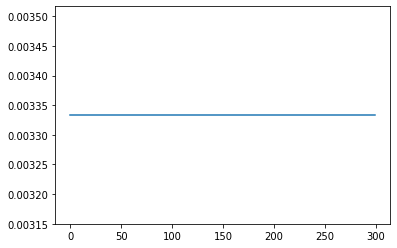

In [6]:
da = generate_uniform(300)
lists = sorted(da.items())
x, y = zip(*lists)
plt.plot(x, y)
plt.show() 

### Aux functions

get_cumulative_prob() GETS THE CUMULATIVE PROBABIITIES OF ITEMS (for later selection)

In [7]:
def get_cumulative_prob(y): 

    cum_prob = {}
    cum_prob[0] = y[0]

    for i in range(1, 300):
        cum_prob[i] = cum_prob[i-1] + y[i]
    return cum_prob

get_playlist() generates a playlist based on the cumulative probabilities its given (for popualar, normal, and rare)

In [8]:
def get_playlists(cum_prob): #CREATES A RANDOM PLAYLLIST

    playlist = [] #empty toy playlist

    #create random playlist (like this bc they dont add to 1)
    while len(playlist) < 20:

        prob = np.random.random()
        #print(prob)
        finished = False
        i = 0
        while i < 300 and finished == False:
            if prob < cum_prob[i] and i not in playlist:
                playlist.append(i)
                finished = True
            i += 1

    playlist.sort()
    return playlist

In [9]:
def get_songs_ordered(songs): #RETURNS A LIST OF SONGS ORDERED BY POPULARITY (AMONG ALL THE PLAYLISTS)
    ordered_songs = []
    songs_copy = copy.deepcopy(songs)

    while songs_copy: 
        max_value = max(songs_copy, key=songs_copy.get)
        ordered_songs.append(max_value)
        songs_copy.pop(max_value)
    #print("Highest used song: ", max_value, " with ", songs_copy[max_value], " instances")
    return ordered_songs

In [10]:
def create_dataframe(list): 
    elems = []
    pred = []
    size = len(list)
    for i in range(size - 1):
        elems.append(list[i])
        pred.append(list[i + 1])
    d = {'Song':elems, 'Next':pred}
    df = pd.DataFrame(d)
    return df

In [11]:
def get_prob_dataframe(probs):
    songs = []
    next = []
    for i in range(len(probs)):
        songs.append(i)
        next.append(probs[i])
    for i in range(len(next[299])):
        next[299][i] = 0
    next[299][298] = 1
    dataframe_next = pd.DataFrame(next)
    d = {'Song': songs}
    df = pd.DataFrame(d)
    result = pd.concat([df, dataframe_next], axis=1, join='inner')
    return result

In case we stop using probabilities use this function not create_dataframe()

In [12]:
def create_training_data(pairs):
    songs = []
    next = []
    for i in range(len(pairs)):
        #max_num = 0
        songs.append(i)
        #max_num = max(pairs[i])
        pred_song = np.argmax(pairs[i])
        next.append(pred_song)
    d = {"Song":songs, "Next":next}
    df = pd.DataFrame(d)
    return df

In [13]:
def split_dataset(dataframe):
    X = dataframe['Song']
    y = dataframe['Next']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    train = {'Song':X_train, 'Next': y_train}
    test = {'Song':X_test, 'Next': y_test}
    return train, test

In [14]:
def split_dataset2(dataframe):
    X = dataframe['Song']
    y = dataframe['Next']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    return X_train, X_test, y_train, y_test

In [15]:
def split_dataset_prob(dataframe):
    X = dataframe['Song']
    dataframe = dataframe.drop('Song', axis=1)
    y = dataframe

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train = X
    y_train = y
    return X_train, X_test, y_train, y_test

In [16]:
def norm_data(data, mean, std):
    songs_norm = (data['Song'] - mean) / std
    data['Song'] = songs_norm
    return data

In case we need tensorflow Datasets

In [17]:
def get_tf_dataset(train, test):
    train_X = tf.data.Dataset.from_tensor_slices(train['Song'])
    train_Y = tf.data.Dataset.from_tensor_slices(train['Next'])

    train_dataset = tf.data.Dataset.zip((train_X, train_Y))
    train_dataset = train_dataset.shuffle(1000).batch(64)
    train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    test_X = tf.data.Dataset.from_tensor_slices(test['Song'])
    test_Y = tf.data.Dataset.from_tensor_slices(test['Next'])

    test_dataset = tf.data.Dataset.zip((test_X, test_Y))
    test_dataset = test_dataset.shuffle(1000).batch(64)
    test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_dataset, test_dataset

create_pairs() creates pairs of numbers, indicating the number of times one appears after the other in the playlists

In [18]:
def create_pairs(playlists): #playlists should be a list of lists, ordered
    pairs = np.zeros((300,300))
    for playlist in playlists:
        for i in range(len(playlist)-1):
            pairs[playlist[i]][playlist[i+1]] += 1
    return pairs

In [19]:
def order_playists(playlists):
    for playlist in playlists:
        playlist.sort()
    return playlists

In [20]:
def get_probabilities(pairs): #Gets the probabilities associated to each pair of numbers, which song is more likely
    for num in range(len(pairs)): #to go after the other
        total = sum(pairs[num])
        pairs[num] /= total
    return pairs

In [21]:
def get_nll(true_song, probs): #true_song has to be in [0,0,0...1,0] format, being the 1 in the correct song index
    nll = 0                     #probs is the output of the nn
    for i in range(len(true_song)):
        nll += true_song[i] * probs[i]
    nll = -np.log(nll)
    return nll

In [22]:
def get_nll_list(expected, idx, predictions): #Returns a list of uncertainties for each prediction
    nll_list = []
    j = 0
    for i in idx:
        true_song = get_true_song(expected[i])
        nll_list.append(get_nll(true_song, predictions[j]))
        j += 1
    return nll_list

In [23]:
def get_true_song(next_songs): #returns expected song, represented as one_hot
    true_song = []
    item = np.argmax(next_songs)
    for i in range(len(next_songs)):
        if i == item:
            true_song.append(1)
            #print("Predicted song: ", item)
        else:
            true_song.append(0)
    return true_song

In [24]:
def transform_predictions(pred): #Transforms the predictions into a one_hot of the most likely song
    max_index = np.argmax(pred)
    new_pred = np.zeros(len(pred))
    new_pred[max_index] = 1
    return new_pred

In [25]:
def get_accuracy(pred, truth):
    count = 0
    size = len(pred)
    for i in range(size):
        cont = True
        j = 0
        while cont and j < size:
            if pred[i][j] != truth[i][j]:
                cont = False
            j += 1
        if cont:
            count += 1
    return count / size

### Model creation

In [26]:
def create_model():
    model = Sequential()
    input = Input(shape=(1,))
    model.add(input)
    model.add(Dense(10, activation='tanh'))
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(30, activation='tanh'))
    model.add(Dense(40, activation='tanh'))
    model.add(Dense(50, activation='tanh'))
    model.add(Dense(60, activation='tanh'))
    model.add(Dense(40, activation='tanh'))
    model.add(Dense(70, activation='tanh'))
    model.add(Dense(300, activation='sigmoid')) #model.add(Dense(1))
    return model

### Visualization functions

In [27]:
def plot_playists_popularity(playists): #FUNCTION THAT PLOTS AL THE SONGS APPEARANCES OF ALL PLAYLISTS
    #playlists is a list of lists

    num_appearances = {} #Dictionary to store the number of times a song is in a playlist

    for playlist in playists:
        for song in playlist:
            if song in num_appearances.keys():
                num_appearances[song] += 1
            else:
                num_appearances[song] = 1

    id, counts = zip(*num_appearances.items())
    plt.scatter(id, counts)
    plt.xlabel("Song number")
    plt.ylabel("Number of appearances")
    plt.show() #BREAK POINT HERE TO SEE THE PLOT
    return num_appearances

In [28]:
def plot_uncertainty_pop(popuarity, uncertainty):
    id, counts = zip(*popuarity.items())
    plot_dict = {}
    i = 0
    for num in counts:
        #what if its already a number
        plot_dict[num] = uncertainty[i]
        i += 1
    pop, unc = zip(*plot_dict.items())
    print(scipy.stats.pearsonr(pop, unc))
    print(scipy.stats.spearmanr(pop, unc))
    print(scipy.stats.kendalltau(pop, unc))
    plt.scatter(pop, unc)
    plt.xlabel("Popuarity")
    plt.ylabel("Uncertainty")
    plt.show() #BREAK POINT HERE TO SEE THE PLOT

## Here it begins

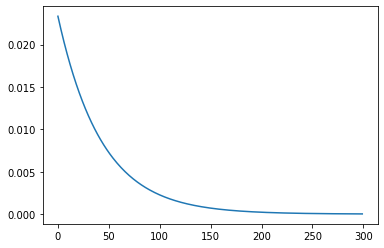

In [29]:
data = generate_exponential(300)
#data = generate_exponential_inv(300)
#data = generate_uniform(300)
lists = sorted(data.items())
x, y = zip(*lists)
cum_prob = get_cumulative_prob(y)
playlist = get_playlists(cum_prob)
plt.plot(x, y)
plt.show() 

In [30]:
random.seed(1234)
playlist_list = []
data_exp = generate_exponential(300)
data_exp_inv = generate_exponential_inv(300)
data_uniform = generate_uniform(300)

data_exp = sorted(data_exp.items())
_, y_exp = zip(*data_exp)

data_exp_inv = sorted(data_exp_inv.items())
_, y_exp_inv = zip(*data_exp_inv)

data_uniform = sorted(data_uniform.items())
_, y_uni = zip(*data_uniform)

In [31]:
type = random.choices(population=[0,1,2], weights=[0.2307,0.6923,0.077], k=3000) #returns a list of choices

cum_prob_exp = get_cumulative_prob(y_exp) #GETS DIFFERENT PROBABIITIES
cum_prob_inv = get_cumulative_prob(y_exp_inv)
cum_prob_uni = get_cumulative_prob(y_uni)

targets = []

for i in type: #GET A RANDOM PLAYLIST OF A SPECIFIC TYPE
    if i == 1:
        pl = get_playlists(cum_prob_exp)
    elif i == 2:
        pl = get_playlists(cum_prob_inv)
    else:
        pl = get_playlists(cum_prob_uni)
    playlist_list.append(pl)
    targets.append(i)

In [32]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(playlist_list, targets, test_size=0.2)

In [33]:
song = []
next_song = []

for playlist in playlist_list:
    for i in range(len(playlist)):
        song.append(playlist[i])
        if i == len(playlist) - 1:
            next_song.append(playlist[0])
        else: next_song.append(playlist[i+1])

X_train3, X_test3, y_train3, y_test3 = train_test_split(song, next_song, test_size=0.2)

d = {'song': song, 'next': next_song}
new_df = pd.DataFrame(d)
new_df
    

,song,next
0,192,196
1,196,211
2,211,223
3,223,230
4,230,235
...,...,...
59995,81,93
59996,93,113
59997,113,114
59998,114,120


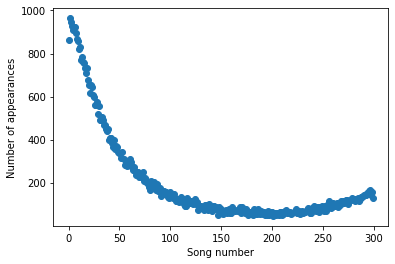

C:\Users\danie\AppData\Local\Temp\ipykernel_1404\4282934075.py:4: RuntimeWarning: invalid value encountered in true_divide
  pairs[num] /= total


In [34]:
popuarity = plot_playists_popularity(playlist_list) #returns the number of appearances of each song
playlists_ordered = order_playists(playlist_list)
pairs = create_pairs(playlist_list) #playlists_ordered
pairs2 = get_probabilities(pairs)
df2 = get_prob_dataframe(pairs2)
df = create_training_data(pairs)

In [35]:
train_data, test_data= split_dataset(df)
#X_train, X_test, y_train, y_test = split_dataset2(df)
X_train, X_test, y_train, y_test = split_dataset_prob(df2)
train_dataset, test_dataset = get_tf_dataset(train_data, test_data)

In [36]:
model = create_model()
callback1 = callbacks.EarlyStopping(monitor='loss', patience=5)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#history = model.fit(train_dataset, epochs=200, validation_data=test_dataset, verbose=1)
history = model.fit(x=X_train, y=y_train, batch_size=1, epochs=200, validation_data=(X_test,y_test))

Epoch 1/200
300/300 [==============================] - 1s 1ms/step - loss: 5.7240 - accuracy: 0.0033 - val_loss: 5.6963 - val_accuracy: 0.0167
Epoch 2/200
300/300 [==============================] - 0s 850us/step - loss: 5.7074 - accuracy: 0.0033 - val_loss: 5.6964 - val_accuracy: 0.0000e+00
Epoch 3/200
300/300 [==============================] - 0s 840us/step - loss: 5.7028 - accuracy: 0.0033 - val_loss: 5.6961 - val_accuracy: 0.0000e+00
Epoch 4/200
300/300 [==============================] - 0s 823us/step - loss: 5.5817 - accuracy: 0.0000e+00 - val_loss: 5.2593 - val_accuracy: 0.0167
Epoch 5/200
300/300 [==============================] - 0s 840us/step - loss: 5.3014 - accuracy: 0.0000e+00 - val_loss: 5.1247 - val_accuracy: 0.0167
Epoch 6/200
300/300 [==============================] - 0s 823us/step - loss: 5.0517 - accuracy: 0.0033 - val_loss: 5.0109 - val_accuracy: 0.0000e+00
Epoch 7/200
300/300 [==============================] - 0s 827us/step - loss: 4.9920 - accuracy: 0.0167 - val_los

In [37]:
#model.save('model_uncertainty.h5')

In [38]:
model = keras.models.load_model('model_uncertainty.h5')

[[2.9400885e-03 9.9169594e-01 9.9358022e-01 ... 3.7662402e-01
  2.9159999e-01 2.5572067e-01]
 [2.9405653e-03 9.9169385e-01 9.9357855e-01 ... 3.7664834e-01
  2.9160365e-01 2.5573924e-01]
 [2.9407144e-03 9.9169326e-01 9.9357808e-01 ... 3.7665063e-01
  2.9160130e-01 2.5574034e-01]
 ...
 [7.5528740e-05 1.6140452e-01 1.7695692e-01 ... 9.1189504e-01
  9.6638882e-01 9.6227455e-01]
 [7.5545955e-05 1.6134405e-01 1.7690420e-01 ... 9.1194844e-01
  9.6641958e-01 9.6230316e-01]
 [7.5562748e-05 1.6128522e-01 1.7685297e-01 ... 9.1200030e-01
  9.6644950e-01 9.6233112e-01]]
0.023333333333333334
(-0.46821226865463467, 9.372793386647417e-11)
SpearmanrResult(correlation=-0.5693747744815729, pvalue=3.6373518492776696e-16)
KendalltauResult(correlation=-0.3793009655922753, pvalue=1.507235631217747e-13)


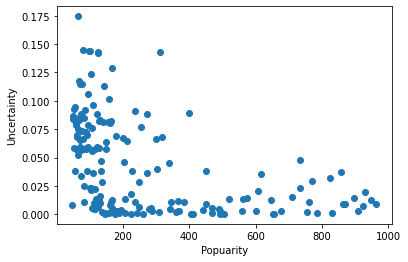

13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
23
23
23
23
23
23
23
23
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
53
53
53
60
60
60
60
60
60
60
60
60
60
60
60
67
67
67
67
67
67
67
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
90
90
90
90
90
90
90
90
90
103
103
103
103
103
103
103
103
103
103
103
103
114
118
118
118
118
118
127
127
127
127
127
127
127
127
127
127
127
127
127
127
127
127
127
127
128
128
128
128
128
128
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298
298


In [39]:
nums = list(range(0,300))
pred = model.predict(nums)
print(pred)
new_pred = []
real_values = []
i = 0
for item in pred:
    new_pred.append(transform_predictions(item))
    real_values.append(transform_predictions(y_train[i]))
    i += 1
print(get_accuracy(new_pred, real_values))
uncertainty = get_nll_list(y_train, nums, pred)
plot_uncertainty_pop(popuarity, uncertainty)
#print(new_pred)
for n in new_pred:
    print(np.argmax(n))

# Test on bayesian probabilistic model

In [40]:
def run_experiment(model, loss, X_train, X_test, y_train, y_test):

    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
        loss=loss,
        metrics=[keras.metrics.RootMeanSquaredError(), 'accuracy'],
    )
    callback = callbacks.EarlyStopping(monitor='accuracy', patience=5)
    print("Start training the model...")
    history = model.fit(x=X_train, y=y_train, epochs=100, validation_data=(X_test, y_test))
    print("Model training finished.")
    #print(model.metrics_names)
    _, rmse, _ = model.evaluate(x=X_train, y=y_train, verbose=0)
    print(f"Train RMSE: {round(rmse, 3)}")

    print("Evaluating model performance...")
    _, rmse, _ = model.evaluate(x=X_test, y=y_test, verbose=0)
    print(f"Test RMSE: {round(rmse, 3)}")
    return history

In [41]:
# Define the prior weight distribution as Normal of mean=0 and stddev=1.
# Note that, in this example, the we prior distribution is not trainable,
# as we fix its parameters.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

In [42]:
def     create_probablistic_bnn_model(train_size):
    inputs = keras.layers.Input(
            name="Song", shape=(1,))
    #features = keras.layers.concatenate(inputs)
    features = keras.layers.BatchNormalization()(inputs)
    
    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in [2, 2]:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="sigmoid",
        )(features)

    # Create a probabilisticå output (Normal distribution), and use the `Dense` layer
    # to produce the parameters of the distribution.
    # We set units=2 to learn both the mean and the variance of the Normal distribution.
    distribution_params = keras.layers.Dense(units=2)(features)
    outputs = tfp.layers.IndependentNormal(1)(distribution_params)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [43]:
X_test2 = X_test.values.tolist()
X_test2

X_train2 = X_train.values.tolist()
len(X_train2)

300

In [44]:
y_test
y_test2 = y_test.values.tolist()
y_test2

y_train2 = y_train.values.tolist()
y_train2

[[0.0,
  0.4918793503480278,
  0.16589327146171692,
  0.10440835266821345,
  0.06728538283062645,
  0.04060324825986079,
  0.042923433874709975,
  0.022041763341067284,
  0.018561484918793503,
  0.010440835266821345,
  0.0069605568445475635,
  0.0069605568445475635,
  0.002320185614849188,
  0.0034802784222737818,
  0.0034802784222737818,
  0.0,
  0.0,
  0.0,
  0.0034802784222737818,
  0.0,
  0.0,
  0.001160092807424594,
  0.0,
  0.0,
  0.0,
  0.001160092807424594,
  0.001160092807424594,
  0.0,
  0.001160092807424594,
  0.001160092807424594,
  0.001160092807424594,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.001160092807424594,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.001160092807424594,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
 

In [45]:
prueba = list(range(20))
print(prueba)
 #TRANSFORM Y_TEST INTO A LIST
prueba = list(y_test2)
#print(prueba)
    

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [46]:
y_train3 = tf.cast(y_train3, tf.int32)
y_test3 = tf.cast(y_test3, tf.int32)

In [47]:
y_train4 = tf.cast(y_train4, tf.int32)
y_test4 = tf.cast(y_test4, tf.int32)

In [48]:
#https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [49]:
#https://keras.io/examples/keras_recipes/bayesian_neural_networks/

def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)


prob_bnn_model = create_probablistic_bnn_model(len(X_train))
history = run_experiment(prob_bnn_model, negative_loglikelihood, X_train, X_test, y_train, y_test)

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Start training the model...
Epoch 1/100
10/10 [==============================] - 2s 45ms/step - loss: 357.6743 - root_mean_squared_error: 1.0513 - accuracy: 0.8609 - val_loss: 241.7690 - val_root_mean_squared_error: 0.8340 - val_accuracy: 0.8027
Epoch 2/100
10/10 [==============================] - 0s 3ms/step - loss: 385.1091 - root_mean_squared_error: 1.1214 - accuracy: 0.8401 - val_loss: 457.9387 - val_root_mean_squared_error: 1.3752 - val_accuracy: 0.8941
Epoch 3/100
10/10 [==============================] - 0s 3ms/step - loss: 338.6328 - root_mean_squared_error: 1.1296 - accuracy: 0.8548 - val_loss: 343.0736 - val_root_mean_squared_error: 1.1807 - val_accuracy: 0.8477
Epoch 4/100
10/10 [==============================] - 0s 3ms/step - loss: 342.9077 - root_mean_squared_error: 1.1055 - accuracy: 0.8021 - val_loss: 342.4641 - val_root_mean_squared_error: 0.9316 - 

In [50]:
prob_bnn_model.evaluate(X_train, y_train, verbose=0)

[-234.1984405517578, 0.19379505515098572, 0.8848555684089661]

In [51]:
prob_bnn_model.evaluate(X_test, y_test, verbose=0)

[-225.21864318847656, 0.2134503722190857, 0.8941110968589783]

In [52]:
print(history.history.keys())

dict_keys(['loss', 'root_mean_squared_error', 'accuracy', 'val_loss', 'val_root_mean_squared_error', 'val_accuracy'])


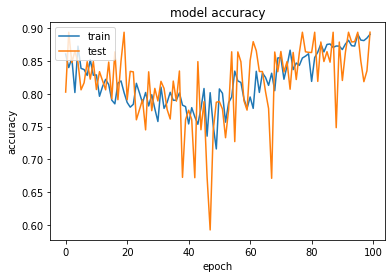

'\nprediction_mean = prediction_distribution.mean().tolist()\nprediction_stdv = prediction_distribution.std()\n\n# The 95% CI is computed as mean ± (1.96 * stdv)\nupper = (prediction_mean + (1.96 * prediction_stdv)).tolist()\nlower = (prediction_mean - (1.96 * prediction_stdv)).tolist()\nprediction_stdv = prediction_stdv.tolist()\n\nprint(prediction_mean)\n\nfor idx in range(10):\n    print(\n        f"Prediction mean: {round(prediction_mean[idx][0], 2)}, "\n        f"stddev: {round(prediction_stdv[idx][0], 2)}, "\n        f"95% CI: [{round(upper[idx][0], 2)} - {round(lower[idx][0], 2)}]"\n        #f" - Actual: {y_copy.iloc[idx]}"\n    )'

In [53]:
list_final = list(range(300))
prediction_distribution = prob_bnn_model.predict(list_final)
#print(X_test)
#print(prediction_distribution)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

"""
prediction_mean = prediction_distribution.mean().tolist()
prediction_stdv = prediction_distribution.std()

# The 95% CI is computed as mean ± (1.96 * stdv)
upper = (prediction_mean + (1.96 * prediction_stdv)).tolist()
lower = (prediction_mean - (1.96 * prediction_stdv)).tolist()
prediction_stdv = prediction_stdv.tolist()

print(prediction_mean)

for idx in range(10):
    print(
        f"Prediction mean: {round(prediction_mean[idx][0], 2)}, "
        f"stddev: {round(prediction_stdv[idx][0], 2)}, "
        f"95% CI: [{round(upper[idx][0], 2)} - {round(lower[idx][0], 2)}]"
        #f" - Actual: {y_copy.iloc[idx]}"
    )"""

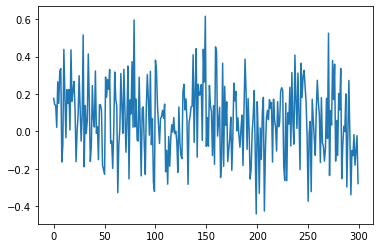

array([[-0.3699267]], dtype=float32)

In [54]:
plt.plot(list_final, prediction_distribution)
plt.show()

try1 = prob_bnn_model.predict([1])
try1

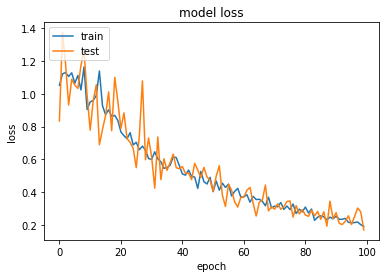

In [55]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [56]:
nll = prediction_distribution[0]
print(nll)
nll = -np.log(abs(nll[0]))
nll

def get_uncertainty(probs):
    return

[0.17606501]


## This function translates the output of the model into an actual song

In [57]:
def get_number(pairs, prob, act_num):
    diff = 2
    num = -1
    for i in range(len(pairs)):
        if abs(pairs[i] - prob) < diff and pairs[i] != 0 and i != act_num:
            diff = abs(pairs[i] - prob)
            num = i

    return num

In [58]:
for i in range(len(prediction_distribution)):
    print(get_number(pairs2[i], prediction_distribution[i], i))

2
3
4
10
6
7
8
8
24
20
11
13
33
15
16
17
26
18
20
21
21
24
40
39
27
26
30
52
31
30
52
33
56
39
35
37
53
55
39
45
48
42
62
57
61
47
48
49
77
74
74
52
53
54
55
56
76
77
81
84
61
62
63
91
86
78
67
68
93
70
71
86
75
74
100
76
77
78
98
80
88
82
99
100
85
101
108
88
92
98
113
92
93
95
112
100
99
100
109
111
101
103
103
116
121
108
120
108
112
110
123
115
117
123
122
129
130
134
124
127
125
130
128
124
141
127
133
128
129
135
131
164
138
136
136
136
138
138
141
145
142
145
144
148
145
146
149
148
149
150
155
155
157
165
155
158
160
160
172
160
166
168
168
164
172
166
170
173
178
174
171
174
176
175
178
183
180
182
181
182
184
185
194
184
189
196
197
188
192
190
197
192
204
195
198
200
197
198
201
206
204
205
205
206
210
212
207
215
210
210
214
217
215
216
219
218
217
218
224
227
226
227
224
228
225
234
231
233
229
237
234
233
233
245
235
239
243
238
239
252
241
243
254
244
245
248
247
250
252
255
257
259
258
261
256
259
271
264
261
260
263
265
280
264
276
275
279
276
269
281
271
279
276
280
2

# Regression test

In [66]:
mean = df['Song'].mean()
std = df['Song'].std()

In [67]:
def make_model(input_fts):
    model = tf.keras.Sequential()
    model.add(Dense(2, input_dim=input_fts))
    return model

In [109]:
def gauss_loss(y_true, y_pred):
    """Negative log likelihood of y_true, with the likelihood defined by a normal distribution."""

    y_true = y_true[:, 0]
    means = y_pred[:, 0]
    # We predict the log of the standard deviation, so exponentiate the prediction here
    stds = tf.exp(y_pred[:, 1])
    variances = stds * stds

    log_p = (-tf.math.log(tf.sqrt(2 * math.pi * variances))
             -(y_true - means)*(y_true - means)/(2 * variances))

    return -log_p

In [127]:
def train_model(X, y):
    """Builds the model, trains it on the given data, and returns the trained model and history."""
    
    # Normalize y to have zero mean and unit variance
    y = y - mean
    y = y / std
    
    num_features = len(X[0])
    model = make_model(num_features)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2,
                                         clipvalue=1,
                                         decay=1e-3)
    model.compile(optimizer=optimizer,
                  loss=gauss_loss)

    history = model.fit(X, y,
                        epochs=100,
                        verbose=False)
    
    return model, history

In [71]:
def predict(model, X):
    
    predictions = model.predict(X)
    
    # Scale up means
    means = predictions[:, 0] * std + mean
    # Exponentiate and scale up log standard deviation
    stds = np.exp(predictions[:, 1]) * std
    
    return means, stds

In [103]:
def num_to_bin(n, length):
    num = n
    binary = []
    while num != 0:
        bit = num % 2
        binary.insert(0, bit)
        num = num // 2
    while len(binary) < length:
        binary.insert(0, 0)
    return np.array(binary)

In [105]:
X = np.array([num_to_bin(n, 10) for n in df['Song']])
X


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 1, 1]])

In [128]:
reg_model, hist = train_model(X, df['Next'].tolist())

Final train loss: -2.5137598514556885


<AxesSubplot:title={'center':'Train Loss per epoch'}>

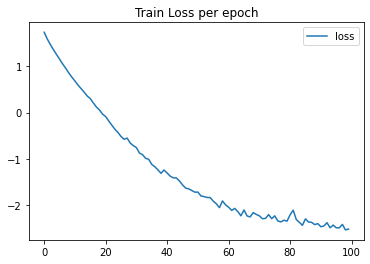

In [129]:
print("Final train loss:", hist.history["loss"][-1])
pd.DataFrame(hist.history).plot(title="Train Loss per epoch")

In [125]:
def visualize_prediction(prediction, actual, filename=None, bgcolor="#ffffff"):
    
    figure = plt.figure()
    
    means, stds = prediction
    prediction_data = pd.DataFrame({"predicted": means,
                                    "actual": actual,
                                    "min": means - stds,
                                    "max": means + stds})
    
    plot = prediction_data[["predicted", "actual"]].plot()
    
    plot.set_facecolor(bgcolor)

    plot.fill_between(prediction_data.index,
                      prediction_data["min"],
                      prediction_data["max"],
                      alpha=0.2, color='k')
    
    #if filename is not None:
    #    plt.savefig(filename, bbox_inches="tight", dpi=200)
    
    return figure, plot

(<Figure size 432x288 with 0 Axes>, <AxesSubplot:>)

<Figure size 432x288 with 0 Axes>

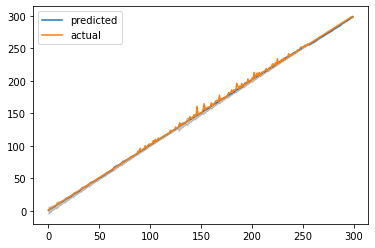

In [130]:
visualize_prediction(predict(reg_model, X), df['Next'].tolist(), "song_prediction.svg")

In [138]:
reg_y_test = np.array([num_to_bin(n, 10) for n in [7, 45, 92, 135, 201, 280, 297]])
means, stds = predict(reg_model, reg_y_test)
print(means[5])
print(stds[5])

279.57895
0.8765708
